# Coursework 2 Part 1
**Replace CID in the file name with your CID**

CID: 02216531

# Outline


- [Task 1](#task-1): Dimensionality Reduction and Regression with Convolutional Neural Networks - CNNs
 <a name="index-task-1"></a>
  - [(1.1)](#task-11) <a name="index-task-11"></a>
  - [(1.2)](#task-12) <a name="index-task-12"></a>
- [Task 2](#task-2): Graph-based learning <a name="index-task-2"></a>
  - [(2.1)](#task-21) <a name="index-task-21"></a>
  - [(2.2)](#task-22)  <a name="index-task-22"></a>

We start by importing all the necessary packages and modules.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
from collections import deque
torch.manual_seed(2)  # Set a fixed seed for reproducibility

We also adjust settings for $\verb|matplotlib|$ as usual.

In [2]:
SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 20
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)   # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

<a name="task-1"></a>

# Task 1: Dimensionality Reduction and Regression with Convolutional Neural Networks - CNNs [(index)](#index-task-1)

Let's first load the dataset and preview it.

In [3]:
# Load the data
data = pd.read_csv("gene_expression_transcriptomic_data.csv")
data.head()

Feature 1: FOXO3  Feature 2: TCF7L2  Feature 3: GSK3B  Feature 4: NRG1  \
0         -3.398452           9.589037          3.529866         6.253610   
1         -0.245484           7.993819          3.765785         6.848617   
2         -0.398032           7.993694          3.682565         6.718451   
3         -1.994980           9.695187          2.937530         6.583533   
4         -1.718202           9.048282          3.347731         6.554885   

   Feature 5: PIK3CB  Feature 6: PRKCE  Feature 7: RHOQ  Feature 8: PLXNA2  \
0           2.481508          4.591092         5.037460           6.916216   
1           2.293223          3.515993         5.675442           6.407153   
2           2.252358          3.551205         5.627892           6.397382   
3           2.088554          4.015317         5.334955           6.681305   
4           2.175890          3.997404         5.352732           6.736506   

   Feature 9: TACC2  Feature 10: DYRK2  ...  Feature 93: LYST  \
0          3.677950           1.744158  ...          0.703886   
1          3.999227           2.780117  ...         -0.942227   
2          3.999275           2.691846  ...          0.410752   
3          3.897753           1.942956  ...         -0.160891   
4          3.798093           2.258191  ...          0.724682   

   Feature 94: MBOAT2  Feature 95: YWHAQ  Feature 96: RRM2  \
0            1.092031          -1.506445         -0.261800   
1           -0.433868          -0.573624         -0.144068   
2            0.136675           0.560848          0.259428   
3           -0.921118           0.464548          0.584903   
4            0.757927           1.112645         -1.813525   

   Feature 97: HPCAL1  Feature 98: LPIN1  Feature 99: MATN3  \
0            0.563489           0.861694           0.573537   
1            0.448680           0.274629          -0.232947   
2            0.177750           0.107654           0.323788   
3           -1.372887          -0.585817          -1.602183   
4            1.741351          -1.603010          -1.097077   

   Feature 100: KLHL29  Target: MAP7  Treatment  
0             0.195488     -4.046991          0  
1            -1.363443    -18.462910          1  
2            -0.546943    -14.027931          1  
3            -3.040662     -4.222716          0  
4            -0.166643    -13.635019          0  

[5 rows x 102 columns]

For this task, we reshape it and split it into three parts with $N^{\mathrm{train}},N^{\mathrm{val}},N^{\mathrm{test}}=1848,264,529$ respectively.

In [4]:
# Extract features and target variable
X = data.iloc[:, 0:100].values
y = data['Target: MAP7'].values

# Reshape to 10 × 10 matrix
X_reshaped = np.reshape(X, (-1, 1, 10, 10))

# Split dataset
Ntrain = 1848
Nval = 264
Ntest = 529
X_train = X_reshaped[:Ntrain]
y_train = y[:Ntrain]
X_val = X_reshaped[Ntrain:Ntrain+Nval]
y_val = y[Ntrain:Ntrain+Nval]
X_test = X_reshaped[Ntrain+Nval:Ntrain+Nval+Ntest]
y_test = y[Ntrain+Nval:Ntrain+Nval+Ntest]

We then verify the shape of these three sets and visualise some of them with the target MAP7 expression level.

In [5]:
(X_train.shape, y_train.shape), (X_val.shape, y_val.shape), (X_test.shape, y_test.shape)

(((1848, 1, 10, 10), (1848,)),
 ((264, 1, 10, 10), (264,)),
 ((529, 1, 10, 10), (529,)))

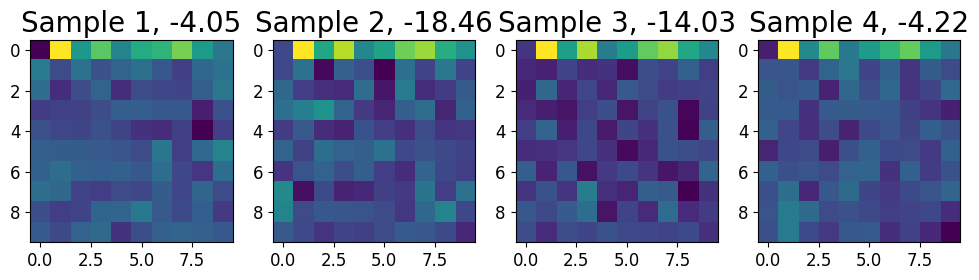

In [6]:
fig, axs = plt.subplots(1, 4, figsize=(12, 8))
for i in range(4):
    axs[i].imshow(np.squeeze(X_train[i]))
    axs[i].set_title(f'Sample {i+1}, {y_train[i]:.2f}')
plt.show()

We can see that most of the data are uniform except for the first row. We will explore them further with the Convolutional Neural Network (CNN) model.

<a name="task-11"></a>

## (1.1) [(index)](#index-task-11)

In this task, we begin by constructing a class for CNN autoencoder that builds upon $\verb|PyTorch|$ with the parameters specified.

In [7]:
class CNNAutoencoder(nn.Module):
    """
    A simple CNN autoencoder model.

    Attributes:
        encoder (nn.Sequential): The encoder part of the model.
        decoder (nn.Sequential): The decoder part of the model.

    Methods:
        forward(x): Forward pass of the model.
    """
    def __init__(self):
        super(CNNAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=8, out_channels=1, kernel_size=3, padding=1, stride=2, output_padding=1),
            nn.ReLU()
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))

We then instantiate the model and test its structure with a random input sample.

In [8]:
model = CNNAutoencoder()
model

CNNAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU()
  )
)

In [9]:
test_input = torch.randn(1, 1, 10, 10)
test_output = model(test_input)
test_input.shape, test_output.shape

(torch.Size([1, 1, 10, 10]), torch.Size([1, 1, 10, 10]))

We use the Mean Squared Error (MSE) of data reconstruction as the loss function and $\verb|Adam|$ as the optimiser.

To train the model, we convert our $\verb|NumPy|$ arrays into tensors, create $\verb|DataLoaders|$ for batching, use the parameters given and include early stopping as well.

We also monitor the performance during training by computing and printing MSE on the training and validation sets every $10$ epochs.

In [10]:
# Loss function: MSE
criterion = nn.MSELoss()

# Optimiser: Adam
optimizer = Adam(model.parameters(), lr=1e-3)

# Convert datasets to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)

# Create DataLoader objects
train_loader = DataLoader(TensorDataset(X_train_tensor, X_train_tensor), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, X_val_tensor), batch_size=32, shuffle=False)

# Training parameters
max_epochs = 100
train_losses, val_losses = [], []

# Early stopping parameters
max_patience = 5
patience = 0
best_val_loss = np.inf

In [11]:
# Training the model
for epoch in range(max_epochs):
    # Training
    model.train()
    train_loss = 0.0
    for batch in train_loader:
        inputs, _ = batch
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, _ in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            val_loss += loss.item() * inputs.size(0)
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)

    # Monitor the progress
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch + 1}/{max_epochs}, Training Loss: {train_loss}, Validation Loss: {val_loss}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience = 0
    else:
        patience += 1
        if patience >= max_patience:
            es_epoch = epoch + 1
            print(f"Early stopping after {es_epoch} epochs.")
            break

Epoch 1/100, Training Loss: 2.6876357871216614, Validation Loss: 1.8840346083496555
Epoch 10/100, Training Loss: 1.5422163788890426, Validation Loss: 1.5294382499926018
Epoch 20/100, Training Loss: 1.4384760201235354, Validation Loss: 1.4370246981129502
Epoch 30/100, Training Loss: 1.410613725711773, Validation Loss: 1.4114891904773135
Epoch 40/100, Training Loss: 1.3987014278188927, Validation Loss: 1.3996368393753513
Epoch 50/100, Training Loss: 1.3913224672342275, Validation Loss: 1.392252387422504
Epoch 60/100, Training Loss: 1.3860829170648155, Validation Loss: 1.3890552015015574
Epoch 70/100, Training Loss: 1.383634631251876, Validation Loss: 1.3861004547639326
Epoch 80/100, Training Loss: 1.3815388535008286, Validation Loss: 1.3851539077180806
Epoch 90/100, Training Loss: 1.38053915098116, Validation Loss: 1.3834059274557866
Early stopping after 96 epochs.


Now that we have the training and validation losses and early stopping epoch, we begin plotting $\mathrm{MSE}_{\mathrm{reconstruct}}$ as a function of the epochs both for the training and validation set, as required, with early stopping epoch $96$ marked as well.

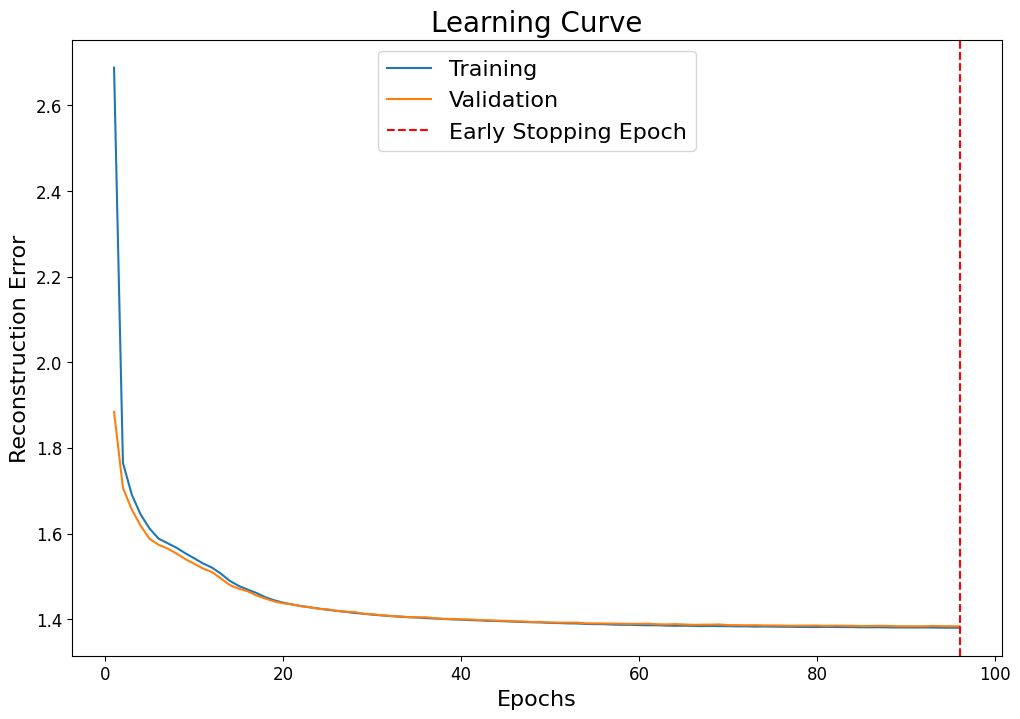

In [12]:
plt.figure(figsize=(12, 8))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation')
plt.axvline(x=es_epoch, color='r', linestyle='--', label='Early Stopping Epoch')
plt.xlabel('Epochs')
plt.ylabel('Reconstruction Error')
plt.title('Learning Curve')
plt.legend()
plt.show()

The learning curve shows rapid decrease during around the first $20$ epochs but converges quickly after that, exhibiting plateau behaviour after about $40$ epochs.

The early stopping criterion was triggered later after $96$ epochs.

We also notice that the gap between training and validation errors is very small, which indicates that no evident overfitting is observed.

We now compute the per-feature reconstruction error and construct the heatmap as required, with logarithm scale due to the outliers, as visualised before in the dataset.

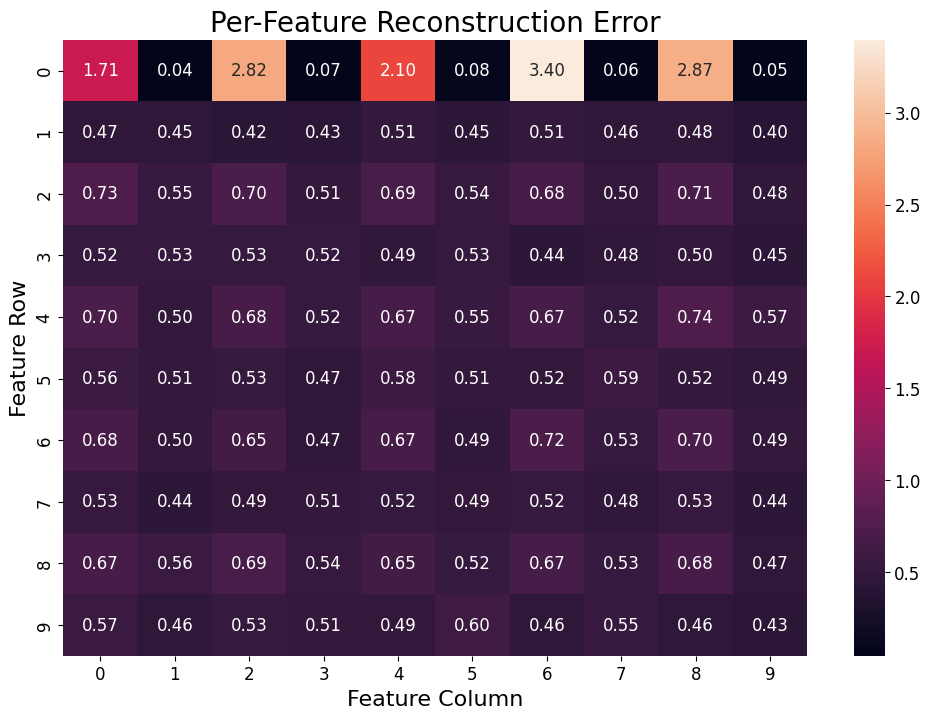

In [13]:
# Compute per-feature reconstruction error on test set
model.eval()
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
with torch.no_grad():
    test_outputs = model(X_test_tensor).squeeze(1)
    reconstruction_errors = (X_test_tensor.squeeze(1) - test_outputs) ** 2
    mse_per_feature = reconstruction_errors.mean(dim=0).numpy()

# Visualise as a 10 × 10 heatmap with logarithm scale
plt.figure(figsize=(12, 8))
sns.heatmap(np.log1p(mse_per_feature), annot=True, fmt=".2f")
plt.xlabel('Feature Column')
plt.ylabel('Feature Row')
plt.title('Per-Feature Reconstruction Error')
plt.show()

From the heatmap, we clearly see that while most gene features have relatively low reconstruction error, some of them (like those in the first row, i.e., the first $10$ features) have visibly larger errors.

This basically indicates that the autoencoder struggled to reconstruct the first several genes.

It is likely that these genes exhibit patterns different from the others, so perhaps we could perform some further investigation on these genes, either biologically or statistically.

<a name="task-12"></a>

## (1.2) [(index)](#index-task-12)

We begin by recalling the structure of the encoder as defined previously:
- A 2-dimensional convolutional layer with 8 filters with kernel shape (3, 3), a ReLU activation function, and padding = 1;
- A max-pooling layer with window shape (2, 2) and stride = 2;
- Another 2-dimensional convolutional layer, identical to the first one.

We are given an input $\mathbf{x}$ which would have shape $\text{(Channels, Height, Width)}=(1,10,10)$, since we reshaped it into a $10\times 10$ matrix.

We know that the output shape of a convolutional layer is given by $\text{Output}=\dfrac{\text{Input+2×Padding−Kernel}}{\text{Stride}}+1$, so $\mathbf{x}$ goes through
- Conv2d: $\text{(Channels, Height, Width)}=(1,10,10)\longrightarrow\left(8,\dfrac{10+2\times 1-3}{1}+1,\dfrac{10+2\times 1-3}{1}+1\right)=(8,10,10)$,
- MaxPool2d: $\text{(Channels, Height, Width)}=(8,10,10)\longrightarrow\left(8,\dfrac{10-2}{2}+1,\dfrac{10-2}{2}+1\right)=(8,5,5)$,
- Conv2d: $\text{(Channels, Height, Width)}=(8,5,5)\longrightarrow\left(8,\dfrac{5+2\times 1-3}{1}+1,\dfrac{5+2\times 1-3}{1}+1\right)=(8,5,5)$,

and the final shape of the output is therefore $\text{(Channels, Height, Width)}=(8,5,5)$ with dimension $8\times 5\times 5=200$.

To visualise the lower-dimensional representations for the data points in the test set, we plot the elements with indices $[1,0,1]$ against the ones with indices $[0,0,0]$.

We first define the CNN encoder in the same way as before.

In [14]:
class CNNEncoder(nn.Module):
    """
    A simple CNN encoder model.

    Attributes:
        encoder (nn.Sequential): The encoder part of the model.

    Methods:
        forward(x): Forward pass of the model.
    """
    def __init__(self):
        super(CNNEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, padding=1),
            nn.ReLU()
        )

    def forward(self, x):
        return self.encoder(x)

We now instantiate an encoder and get the lower-dimensional representations.

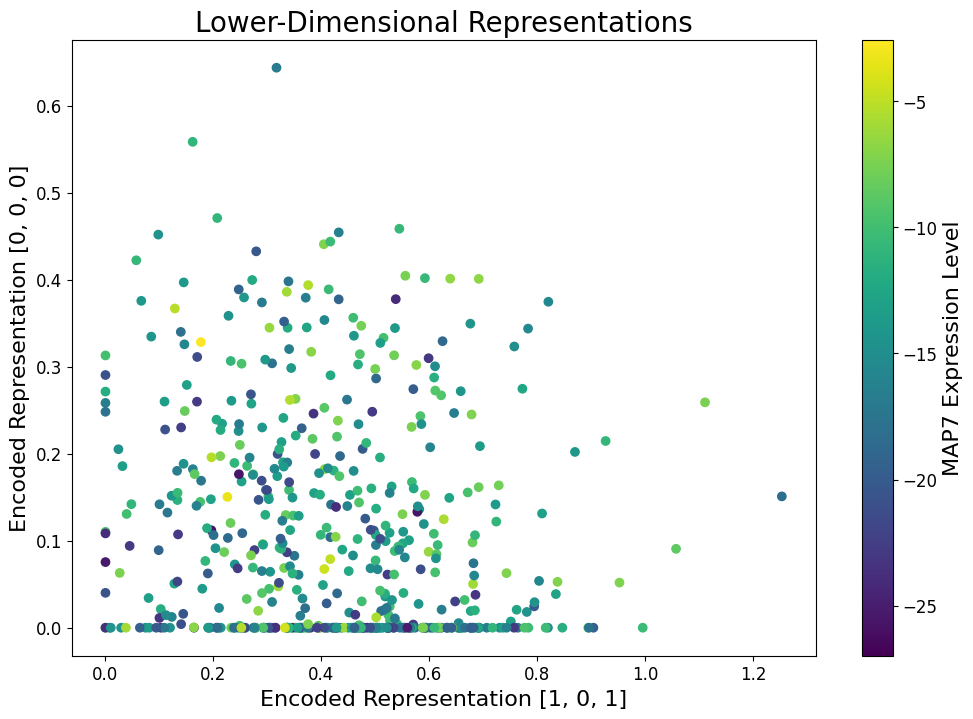

In [15]:
# Instantiate an encoder
model = CNNEncoder()

# Get the lower-dimensional representations
with torch.no_grad():
    encoded_test = model(X_test_tensor).numpy()

# Plotting
plt.figure(figsize=(12, 8))
scatter = plt.scatter(encoded_test[:, 1, 0, 1], encoded_test[:, 0, 0, 0], c=y_test)
plt.colorbar(scatter, label='MAP7 Expression Level')
plt.xlabel('Encoded Representation [1, 0, 1]')
plt.ylabel('Encoded Representation [0, 0, 0]')
plt.title('Lower-Dimensional Representations')
plt.show()

In the plot, we can see that the data points are widely spread and scattered across the space, with no clear clustering pattern immediately observable (except for some points lying on the straight line at $y=0.0$), so these encoded features may be highly variable and not easily separable.

To explore the data further, we build a CNN regressor as required, with similar structure as before; we use $\verb|torch.flatten|$ to flatten the encoder’s output.

In [16]:
class CNNRegressor(nn.Module):
    """
    A simple CNN regressor model.

    Attributes:
        encoder (nn.Sequential): The encoder part of the model.
        regressor (nn.Sequential): The regressor part of the model.

    Methods:
        forward(x): Forward pass of the model.
    """
    
    def __init__(self):
        super(CNNRegressor, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.regressor = nn.Sequential(
            nn.Flatten(),
            nn.Linear(200, 1)
        )

    def forward(self, x):
        return self.regressor(torch.flatten(self.encoder(x), start_dim=1)).squeeze()

We the proceed to training the model and test its performance. We first define all the parameters as given.

In [17]:
# Instantiate the model
model = CNNRegressor()

# Optimiser: Adam
optimizer = Adam(model.parameters(), lr=1e-3)

# Convert datasets to tensors
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

# Create DataLoader objects
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=32, shuffle=False)

# Training parameters
max_epochs = 1000
train_losses, val_losses = [], []

# Early stopping parameters
max_patience = 10
patience = 0
best_val_loss = np.inf

In [18]:
# Training the model
for epoch in range(max_epochs):
    # Training
    model.train()
    train_loss = 0.0
    for batch in train_loader:
        inputs, targets = batch
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)

    # Monitor the progress
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch + 1}/{max_epochs}, Training Loss: {train_loss}, Validation Loss: {val_loss}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience = 0
    else:
        patience += 1
        if patience >= max_patience:
            print(f"Early stopping after {epoch + 1} epochs.")
            break

Epoch 1/1000, Training Loss: 120.91371331483255, Validation Loss: 27.545038396661933
Epoch 10/1000, Training Loss: 17.545136864567215, Validation Loss: 16.82199663104433
Epoch 20/1000, Training Loss: 8.847228215370343, Validation Loss: 8.642563097404711
Epoch 30/1000, Training Loss: 8.142738635405834, Validation Loss: 8.096858544783158
Epoch 40/1000, Training Loss: 7.88046544351619, Validation Loss: 8.04657100908684
Epoch 50/1000, Training Loss: 7.63225557071306, Validation Loss: 8.077311775901101
Epoch 60/1000, Training Loss: 7.451631096018342, Validation Loss: 7.8352829904267285
Epoch 70/1000, Training Loss: 7.319704592485965, Validation Loss: 7.848650946761623
Early stopping after 78 epochs.


Both the training loss and the validation loss seem to converge fast, and the early stopping condition was triggered after $78$ epochs. We are now ready to compute the $R^2$ value with the formula $$R^2=1-\dfrac{\mathrm{RSS}}{\mathrm{TSS}}=1-\dfrac{\mathrm{MSE}}{\mathrm{Var}(y_\mathrm{test})},$$ where RSS = Residual Sum of Squares, TSS = Total Sum of Squares which can be represented by MSE and variance of the test set respectively.

In [19]:
model.eval()
y_test_tensor = torch.tensor(y_test).float()
with torch.no_grad():
    predictions_test = model(X_test_tensor)
    test_loss = criterion(predictions_test, y_test_tensor).item()
1 - (test_loss / np.var(y_test_tensor.numpy()))

0.6815676504521679

We can see that the $R^2$ value is $\approx 0.68$, which is reasonably close to $1$. This suggests that the model has a reasonably successful predictive performance. The regressor effectively reduces dimensionality in this case, so it could be used to capture meaningful biological signals for the MAP7 expression level.

<a name="task-2"></a>

# Task 2: Graph-based learning [(index)](#index-task-2)

We are now ready to move on to the next task. We start by extracting the dataset with the code given.

In [20]:
dataset = pd.read_csv("gene_expression_transcriptomic_data.csv")
X = dataset.iloc[:400, :10].values # extract the first 400 rows and 10 columns
treatment = dataset.iloc[:, 101].values[:400, ] # extract the corresponding 400 treatment labels

<a name="task-21"></a>

## (2.1) [(index)](#index-task-21)

We first compute the matrix $S$ of cosine similarities, which is defined as $S_{ij}=\dfrac{\mathbf{x}_i\cdot\mathbf{x}_j}{\left|\mathbf{x}_i\right|\left|\mathbf{x}_j\right|}$ for each $1\le i,j\le n$. We use $\verb|numpy|$ to find the norm and dot product.

In [21]:
def cosine_similarity(X):
    norms = np.linalg.norm(X, axis=1, keepdims=True)
    X_normalized = X / norms
    return np.dot(X_normalized, X_normalized.T)
S = cosine_similarity(X)

We can also verify the shape and a small portion of the matrix. We would expect all elements to have values close to $1$ and all diagonal elements equal to $1$.

In [22]:
S.shape, S[:5, :5]

((400, 400),
 array([[1.        , 0.97082295, 0.97381618, 0.99425195, 0.9928405 ],
        [0.97082295, 1.        , 0.99989861, 0.98527825, 0.99162885],
        [0.97381618, 0.99989861, 1.        , 0.98733441, 0.99320757],
        [0.99425195, 0.98527825, 0.98733441, 1.        , 0.99863847],
        [0.9928405 , 0.99162885, 0.99320757, 0.99863847, 1.        ]]))

For the next part, we are given a way to sparsify the graph $G_\mathrm{dense}$ with $A_{ij}^{(\delta)}=S_{ij}$ if $S_{ij}\ge\delta$ and $0$ otherwise, so that only edges with weights $\ge\delta$ remain.

First, we compute $n(\delta)$, the number of connected components of $G^{(δ)}$, with a BFS (Breadth-First Search) algorithm using $\verb|deque|$ from $\verb|collections|$.

For a given adjacency matrix $A$, we traverse the graph, and for each unvisited node, we:
- add the component count by $1$,
- perform a BFS from this node, marking all reachable nodes as visited,
- repeat until all nodes are visited.

It could be easily shown that the total number of BFS traversals is equal to the number of connected components. The algorithm is implemented as follows.

In [23]:
def connected_components(A):
    """
    Compute n(δ).

    Arguments:
        A: the adjacency matrix of the graph

    Returns:
        components: the number of connected components
    """
    visited = np.zeros(A.shape[0], dtype=bool)
    components = 0
    for node in range(A.shape[0]):
        if not visited[node]:
            components += 1
            queue = deque([node])
            visited[node] = True
            while queue:
                current = queue.popleft()
                neighbors = np.nonzero(A[current])[0]
                for neighbor in neighbors:
                    if not visited[neighbor]:
                        visited[neighbor] = True
                        queue.append(neighbor)
    return components

We now proceed to $s(\delta)$, defined to be the ratio of the number of edges in $G^{(\delta)}$ and the maximal number of edges.

The latter can be calculated by $\displaystyle\binom{N}{2}=\dfrac{N(N-1)}{2}=\dfrac{400(400-1)}{2}=79800$, which is the case of a complete graph.

For the former, notice that since the graph is undirected, the adjacency matrix is symmetric, so we only count edges in the upper triangle, with $\verb|np.count_nonzero(np.triu(A_delta))|$.

We can now find $\delta^*$ that keeps the graph entirely connected (i.e., there is one and only one connected component) with $200$ equidistant values from $\min(S)$ to $\max(S)$.

In [24]:
# Initialisation
n_delta = []
s_delta = []
delta_values = np.linspace(S.min(), S.max(), 200)
delta_star = None
max_edges = 79800

# Loop over each threshold δ
for delta in delta_values:
    # Sparsified adjacency matrix
    A_delta = np.where((S >= delta) & (~np.eye(S.shape[0], dtype=bool)), S, 0)

    # Calculate connected components
    components = connected_components(A_delta)
    n_delta.append(components)

    # Calculate sparsity
    s_delta.append(np.count_nonzero(np.triu(A_delta)) / max_edges)

    # Identify δ* which keeps the graph entirely connected
    if components == 1:
        delta_star = delta

delta_star

0.9990089178198224

We have therefore evaluated $\delta^*\approx0.999$. We now plot $n(\delta)$ and $s(\delta)$ with respect to $\delta$ with $\delta^*$ marked as well on the same plot.

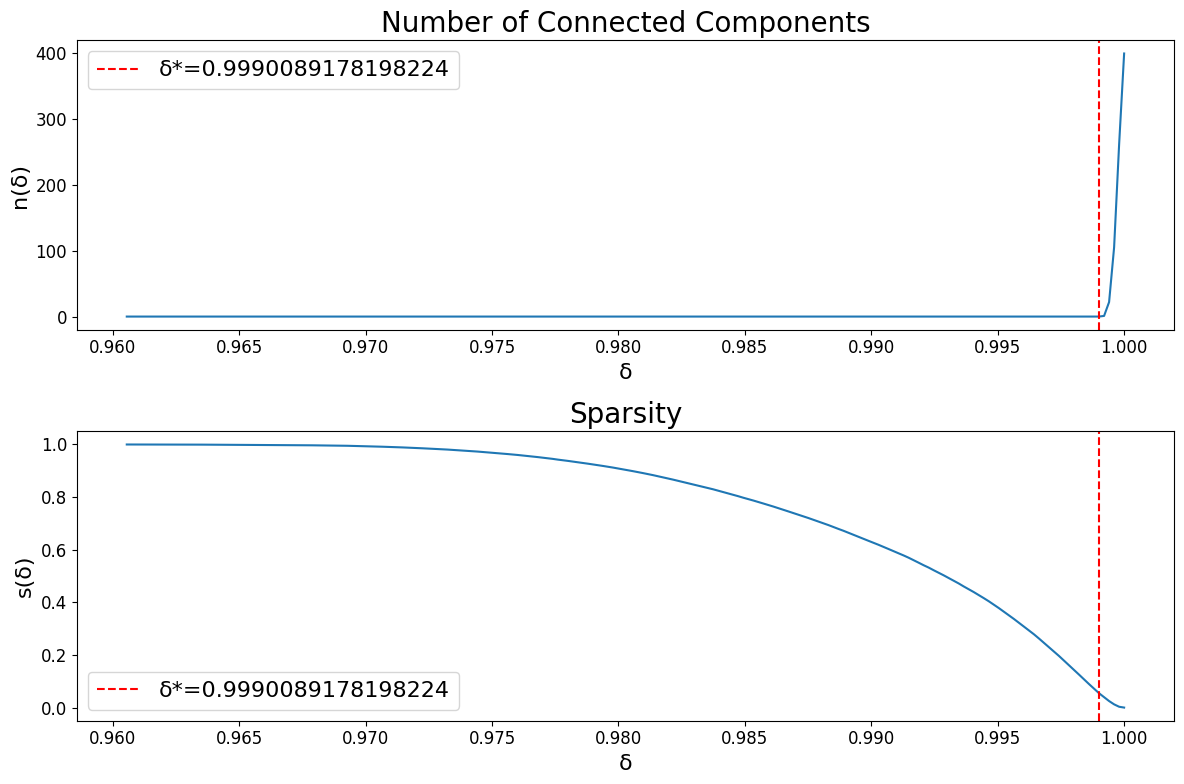

In [25]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

ax1.plot(delta_values, n_delta)
ax1.set_xlabel('δ')
ax1.set_ylabel('n(δ)')
ax1.set_title('Number of Connected Components')
ax1.axvline(x=delta_star, color='r', linestyle='--', label=f'δ*={delta_star}')
ax1.legend()

ax2.plot(delta_values, s_delta)
ax2.set_xlabel('δ')
ax2.set_ylabel('s(δ)')
ax2.set_title('Sparsity')
ax2.axvline(x=delta_star, color='r', linestyle='--', label=f'δ*={delta_star}')
ax2.legend()

plt.tight_layout()
plt.show()

The plots show that for values of $\delta<\delta^*$, the number of connected components $n(\delta)$ is always equal to $1$, which is as expected, but increases rapidly when $\delta\ge\delta^*$, so that the components begin to fragment and the graph loses its connectedness very quickly.

For the sparsity $s(\delta)$, we can see that while it remains roughly constant at $1.0$ initially, it begins to decrease as $\delta$ increases, and the magnitude of the gradient steadily increases as well, indicating that the graph becomes more and more sparse and loses edges at an accelerating rate. As $\delta$ approaches $1.0$, the sparsity tends to $0.0$ which is when the graph is completely unconnected.

We can now compute the adjacency matrix at $\delta=\delta^*$ and show its sparsity.

In [26]:
A_final = np.where((S >= delta_star) & (~np.eye(S.shape[0], dtype=bool)), S, 0)
num_edges = np.count_nonzero(np.triu(A_final))
num_edges / max_edges

0.0543734335839599

The sparsity level is therefore $\approx 0.054$, indicating that only about $5.4\%$ of the possible edges are present. This is a reasonably sparse graph, but still entirely connected.

We can finally begin to plot the graph using the spectral layout introduced in the notebook from Week 9. We will utilise the function $\verb|plot_graph|$ from there.

In [27]:
N = A_final.shape[0]
def plot_graph(adjacency, x_coord, y_coord, node_size, node_color):
    """
    Plot undirected graph.

    Parameters:
        adjacency (np.array): N x N adjacency matrix.
        x_coord (np.array): X-coordinates for N nodes.
        y_coord (np.array): Y-coordinates for N nodes.
        node_size (np.array): Size for each of the N nodes.
        node_color (np.array): Color for each of the N nodes.
    """
    fig, ax = plt.subplots(1, figsize=(12, 8))
    for i in range(N):
        for j in range(i+1,N):
            if adjacency[i,j] > 0:
                ax.plot([x_coord[i],x_coord[j]],[y_coord[i],y_coord[j]], color="black", alpha=0.5, linewidth=0.3)
    scatter = ax.scatter(x_coord,y_coord,s=0.2*node_size, c=node_color, zorder=10)
    return ax

To compute the normalised symmetric graph Laplacian, we use the formula $L_\text{sym}=D^{-1/2} L D^{-1/2}$ where $L=D-A$ is the combinatorial Laplacian and $D$ the diagonal degree matrix as given in lecture notes.

In [28]:
d = np.sum(A_final, axis=1)
D = np.diag(d)
L = D - A_final
D_sqrt_inv = np.diag(1/np.sqrt(d))
L_s = D_sqrt_inv @ L @ D_sqrt_inv

We then compute its eigenvalues and eigenvectors and obtain relevant coordinates for plotting (the second and third eigenvectors).

In [29]:
eigenvals, eigenvecs = np.linalg.eigh(L_s)
x_coords, y_coords = eigenvecs[:, 1], eigenvecs[:, 2]

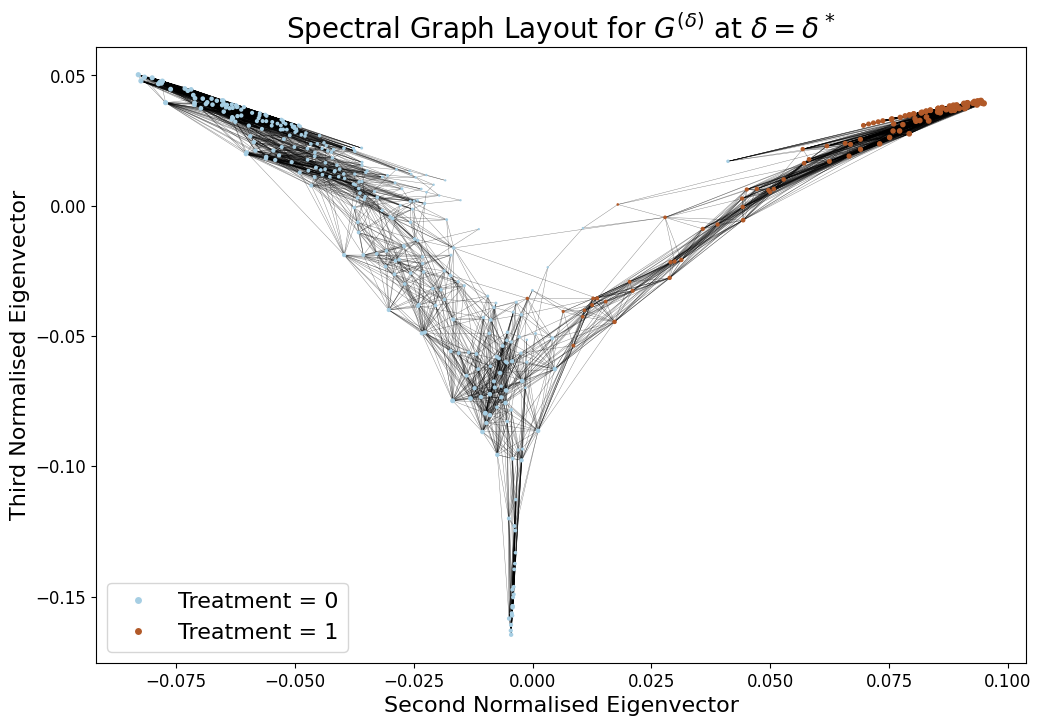

In [30]:
value_to_type = {0: "Treatment = 0", 1: "Treatment = 1"}
cmap = plt.get_cmap("Paired", 2)
node_color = [cmap(i) for i in treatment]
node_size = d
ax = plot_graph(adjacency=A_final, x_coord=x_coords, y_coord=y_coords, node_size=node_size, node_color=node_color)
ax.set(xlabel="Second Normalised Eigenvector", ylabel="Third Normalised Eigenvector", title=f"Spectral Graph Layout for $G^{{(\\delta)}}$ at $\\delta=\\delta^*$")
types_legend = [plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=cmap(value)) for value, label in value_to_type.items()]
ax.legend(handles=types_legend)
plt.show()

As can be seen in the spectral layout, the nodes form a "Y"-shaped structure, with roughly two branches for the two respective treatment groups, which suggests natural clustering within the network.

<a name="task-22"></a>

## (2.2) [(index)](#index-task-22)

To compute the degree centrality, we simply use the formula given in lecture notes $c_d=\dfrac{d}{2E}$ where $d$ is the degree we just calculated and $E$ is the number of edges. We then plot a histogram of the centralities for the two different treatment labels based on this.

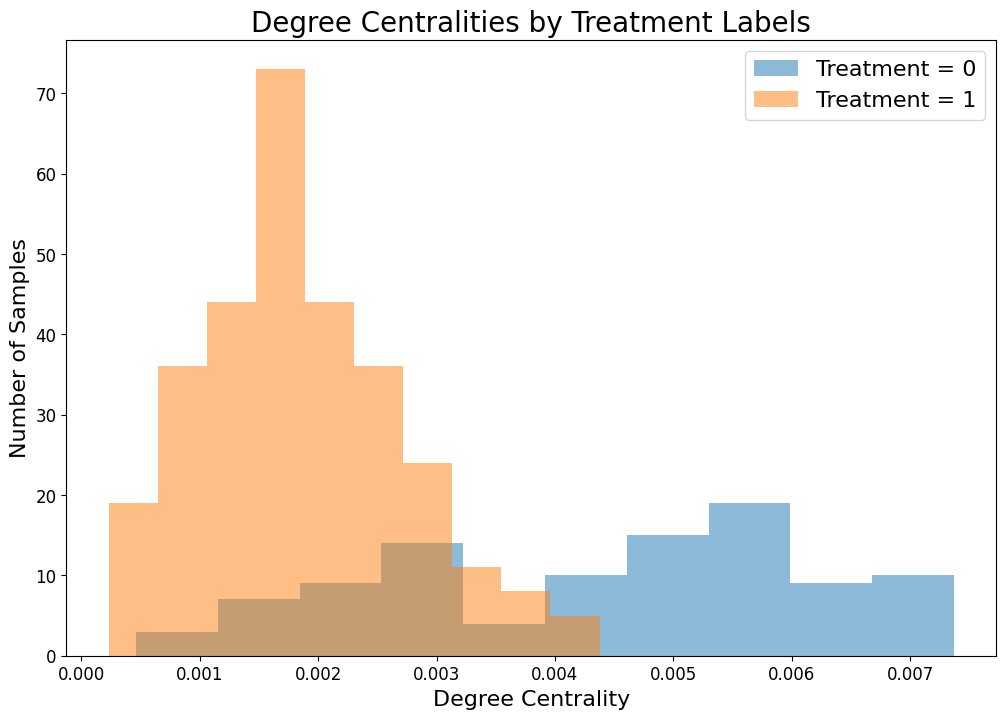

In [31]:
degree_centrality = d / (2 * num_edges)
plt.figure(figsize=(12, 8))
plt.hist(degree_centrality[treatment == 1], label='Treatment = 0', alpha = 0.5)
plt.hist(degree_centrality[treatment == 0], label='Treatment = 1', alpha = 0.5)
plt.xlabel('Degree Centrality')
plt.ylabel('Number of Samples')
plt.title('Degree Centralities by Treatment Labels')
plt.legend()
plt.show()

Finally, we want to calculate the mean degree for the two groups of samples.

In [32]:
np.mean(d[treatment == 1]), np.mean(d[treatment == 0])

(38.4694430333565, 16.085932336363708)

Apparently, the mean degree for the $\text{Treatment = 1}$ sample, $38.47$, is larger than that for the $\text{Treatment = 0}$ sample, $16.09$. From the histogram, we can also see that the $\text{Treatment = 1}$ sample have lower connectivity and lower centrality, possibly indicating weaker co-expression relationships, and the $\text{Treatment = 0}$ sample are more spread out with higher centrality, so their interactions are probably stronger.